# House Prices - Advanced Regression Techniques
[ссылка](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)

## 1.Импорт необходимых библиотек

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

## 2.Работа с данными

### 2.1 Загрузка данных

In [2]:
data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')

submission = pd.read_csv('data/sample_submission.csv')

### 2.2 Изучение и анализ данных

In [3]:
data_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
data_train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

#### Исследование на пропуски

In [5]:
data_train.isnull().sum().sort_values(ascending=False)[:15]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
dtype: int64

Из-за того что в столбцах PoolQC, MiscFeature, Alley, Fence, FireplaceQu, LotFrontage слишком много пропущенных значений, удаляем их их таблицы. В остальных признаках заполним пропуски модой.

In [6]:
for_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage']
data_train = data_train.drop(columns=for_drop)
data_test = data_test.drop(columns=for_drop)

In [7]:
data_train = data_train.fillna(data_train.mode().iloc[0])
data_test = data_test.fillna(data_train.mode().iloc[0])

In [8]:
num_cols = [
    'LotArea',
    'YearBuilt', 
    'YearRemodAdd',
    'MasVnrArea',
    'BsmtFinSF1', 
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    '1stFlrSF',
    '2ndFlrSF',
    'LowQualFinSF',
    'GrLivArea',
    'BsmtFullBath',
    'BsmtHalfBath',
    'FullBath',
    'HalfBath',
    'BedroomAbvGr',
    'KitchenAbvGr',
    'TotRmsAbvGrd',
    'Fireplaces',
    'GarageYrBlt',
    'GarageCars',
    'GarageArea',
    'WoodDeckSF',
    'OpenPorchSF',
    'EnclosedPorch',
    '3SsnPorch',
    'ScreenPorch',
    'PoolArea',
    'MiscVal',
    'MoSold',
    'YrSold'
]

cat_cols = [
    'MSSubClass',
    'MSZoning',
    'Street',
    'LotShape',
    'LotConfig', 
    'Neighborhood',
    'Condition1',
    'Condition2', 
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Foundation', 
    'Heating',
    'CentralAir', 
    'Electrical',
    'KitchenQual',
    'Functional',
    'GarageType',
    'PavedDrive',
    'SaleType', 
]

rang_cols = [
    'LandContour',
    'Utilities',
    'LandSlope',
    'OverallQual',
    'OverallCond',
    'ExterQual',
    'ExterCond',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'HeatingQC',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'SaleCondition'
]

target = ['SalePrice']

In [9]:
len(cat_cols)

24

#### Исследование численных признаков

<AxesSubplot:>

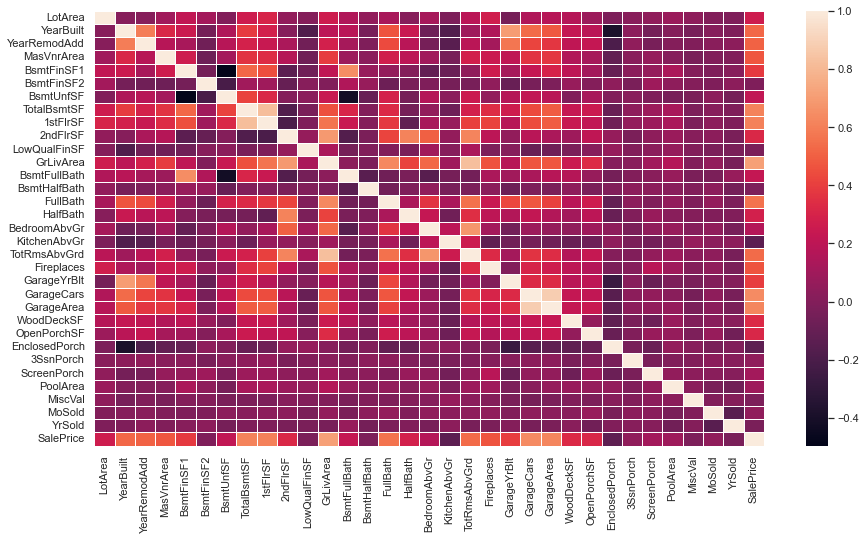

In [10]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(data_train[num_cols+target].corr(), linewidth=.5)

Как видно из карты корреляции, есть значимая зависимость между некоторыми переменными, а именно: 
- TotalBsmtSF и 1stFlrSF (Логичнее будет оставить площадь первого этажа)
- GrLivArea и TotRmsAbvGrd (Оставляем жилую площадь надземной части)
- YearBuilt и GarageYrBlt (Оставляем год постройки)
- GarageCars GarageArea (Оставляем площадь гаража)

#### Исследование ранжированных переменных

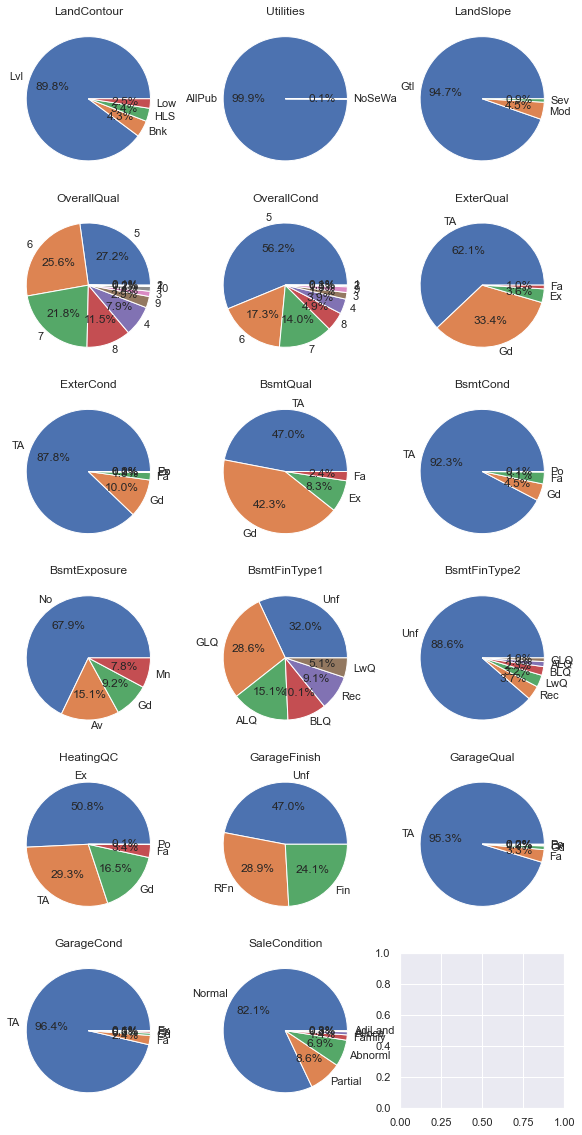

In [11]:
fig, axes = plt.subplots(6, 3, figsize=(10, 20))
colors = sns.color_palette('pastel')[0:5]
for ax, col in zip(axes.flatten(), rang_cols):
    ax.set_title(col)
    ax.pie(data_train[col].value_counts(), autopct="%1.1f%%", labels=data_train[col].value_counts().index)
    

Из полученных диаграмм можно сделать выводы по поводу этих признаков:
1. LandContour - можно объединить Low, HLS, Bnk и отнести этот признак к категориальной переменной;
2. Utilities, LandSlope, ExterCond, BsmtCond, BsmtFinType2, GarageQual, GarageCond - наблюдается явный дисбаланс классов, следовательно эти признаки лучше удалить;
3. OverallQual - можно сделать следующие объединения: (1, 2, 3, 4, 5) и (8,9,10);
4. OverallCond - можно сделать следующие объединения: (1, 2, 3, 4, 5) и (8,9,10);
5. ExterQual - можно объединить Ex c Gd, а Fa и Po с Ta, и отнести этот признак к категориальной переменной;
6. BsmtQual - можно объединить Ex c Gd, а Fa с Ta, и отнести этот признак к категориальной переменной;
7. HeatingQC - можно объединить Po, Fa c Ta;
8. SaleCondition - можно объединить Abnorml, AdjLand, Alloca, Family, Partial и отнести этот признак к категориальной переменной;

In [12]:
patterns = {
    'Lvl': 1,	
    'Bnk': 0,
    'HLS': 0,
    'Low': 0,
    1:0,
    2:0,
    3:0,
    4:0,
    5:0,
    6:1,
    7:2,
    8:3,
    9:3,
    10:3,
    'Ex': 3,
    'Gd': 3,
    'TA': 0,
    'Fa': 0,
    'Po': 0,
    'NA': 0,

    'Av': 2,	
    'Mn': 1,
    'No': 0,

    'GLQ': 6,
    'ALQ': 5,
    'BLQ': 4,
    'Rec': 3,
    'LwQ': 2,
    'Unf': 1,
    
    'Fin': 3,
    'RFn': 2,

    'Normal': 1,
    'Abnorml': 0,
    'AdjLand': 0,
    'Alloca': 0,
    'Family': 0,
    'Partial':0

}

In [13]:
data_train[rang_cols] = data_train[rang_cols].replace(patterns)
data_test[rang_cols] = data_test[rang_cols].replace(patterns)

#### Исследование категориальных признаков

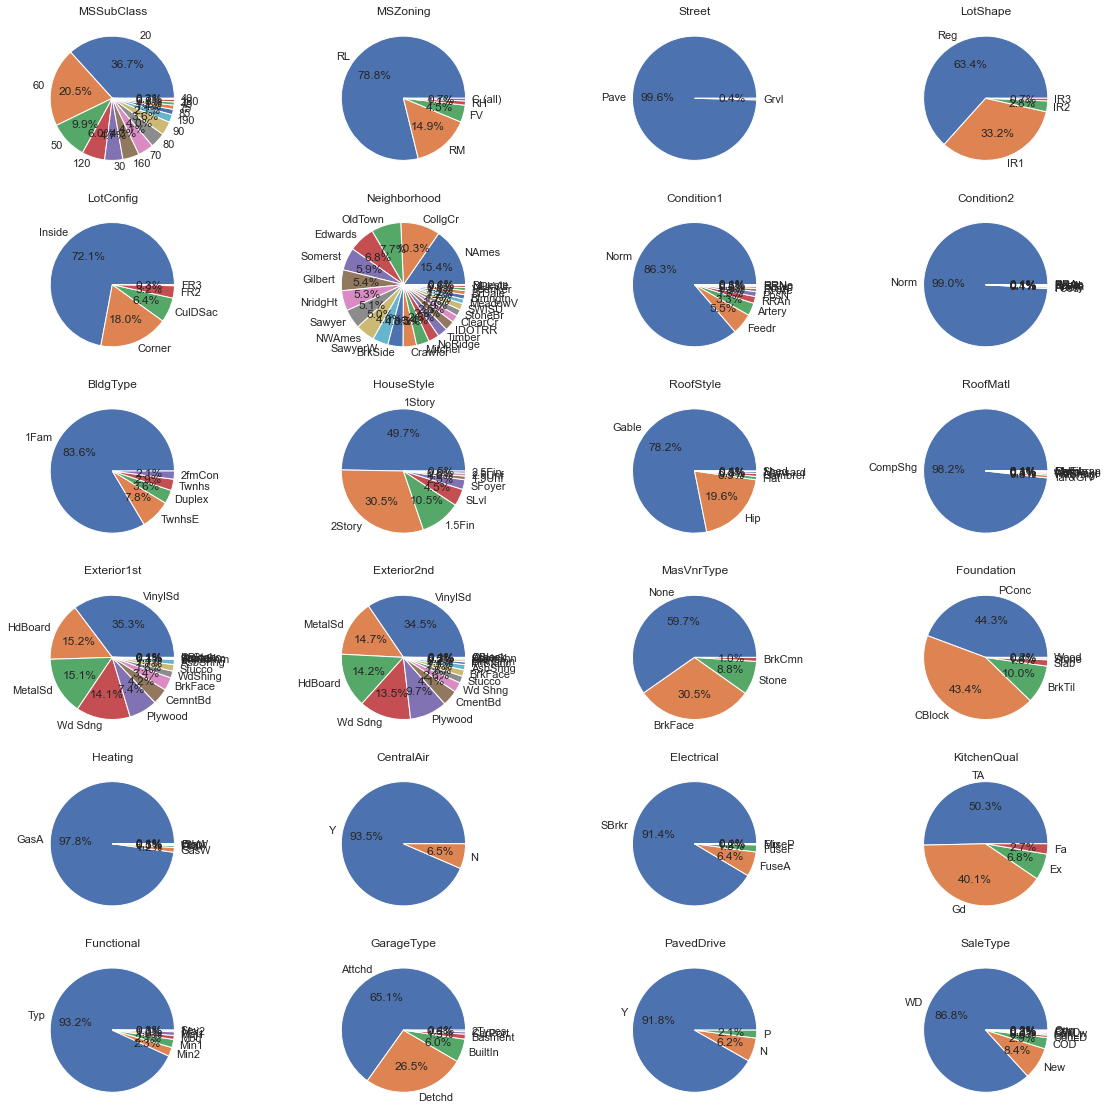

In [14]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20))
colors = sns.color_palette('pastel')[0:5]
for ax, col in zip(axes.flatten(), cat_cols):
    ax.set_title(col)
    ax.pie(data_train[col].value_counts(), autopct="%1.1f%%", labels=data_train[col].value_counts().index)

Из полученных диаграмм можно сделать выводы по поводу этих признаков:
1. Street, Condition1, Condition2, RoofMatl, Heating, CentralAir, Elctrical, Functional, PavedDrive, SaleType - наблюдается дисбаланс классов, следовательно эти признаки лучше удалить;
2. LotShape - объединить IR1, IR2, IR3 в один класс IR
3. LotConfig - объединить FR2 и FR3 в FR
4. HouseStyle, MSZoning, RoofStyle, Exterior1st, Exterior2nd, Foundation, GarageType - объединить в Other мелкие классы
5. MasVnrType - объединить BrkCmn и BrkFace в Brk
6. MSSubClass, Neighborhood - слишком много классов, которые не будут давать особой пользы, поэтому удаляем их

In [15]:
patterns = {
    'IR1': 'IR',	
    'IR2': 'IR',
    'IR3': 'IR',
    'FR2': 'FR',
    'FR3': 'FR',
    'BrkCmn': 'Brk',
    'BrkFace': 'Brk',
    
    '1.5Fin': 'Other',
    '1.5Unf': 'Other',
    '2.5Fin': 'Other',
    '2.5Unf': 'Other',
    'SFoyer': 'Other',
    'SLvl': 'Other',

    'A': 'Other',
    'C': 'Other',
    'FV': 'Other',
    'I': 'Other',
    'RH': 'Other',
    'RP': 'Other',

    'Flat': 'Other',
    'Gambrel': 'Other',
    'Mansard': 'Other',
    'Shed': 'Other',
    
    'AsbShng': 'Other',
    'AsphShn': 'Other',
    'BrkComm': 'Other',
    'BrkFace': 'Other',
    'CBlock': 'Other',
    'CemntBd': 'Other',
    'ImStucc': 'Other',
    'Other': 'Other',
    'PreCast': 'Other',
    'Stone': 'Other',
    'Stucco': 'Other',
    'WdShing': 'Other',
    'CemntBd': 'Other',
    'Wd Shng': 'Other',
    'Brk Cmn': 'Other',
    'Brk': 'Other',
    
    'BrkTil': 'Other',
    'Slab': 'Other',
    'Stone': 'Other',
    'Wood': 'Other',

    '2Types': 'Other',
    'Basment': 'Other',
    'BuiltIn': 'Other',
    'CarPort': 'Other',
    'NA': 'Other',

    'Ex': 3,
    'Gd': 3,
    'TA': 0,
    'Fa': 0,
    'Po': 0,
    'NA': 0
}

In [16]:
data_train[cat_cols] = data_train[cat_cols].replace(patterns)
data_test[cat_cols] = data_test[cat_cols].replace(patterns)

In [17]:
for_drop = [
    'TotalBsmtSF',
    'TotRmsAbvGrd',
    'GarageYrBlt',
    'GarageCars',
    'Utilities', 
    'LandSlope', 
    'ExterCond', 
    'BsmtCond', 
    'BsmtFinType2', 
    'GarageQual', 
    'GarageCond',
    'Street', 
    'Condition1', 
    'Condition2', 
    'RoofMatl', 
    'Heating', 
    'CentralAir', 
    'Electrical', 
    'Functional', 
    'PavedDrive', 
    'SaleType',
    'MSSubClass', 
    'Neighborhood'
]
data_train = data_train.drop(columns=for_drop)
data_test = data_test.drop(columns=for_drop)

#### Общее исследование

После того как мы рассмотрели по отдельности каждый тип переменной, посмотрим на всю картину в целом. Обработанные ранговые типы переменных можно разделить на категориальные и численные.

In [18]:
num_cols = [
    'LotArea',
    'YearBuilt', 
    'YearRemodAdd',
    'MasVnrArea',
    'BsmtFinSF1', 
    'BsmtFinSF2',
    'BsmtUnfSF',
    '1stFlrSF',
    '2ndFlrSF',
    'LowQualFinSF',
    'GrLivArea',
    'BsmtFullBath',
    'BsmtHalfBath',
    'FullBath',
    'HalfBath',
    'BedroomAbvGr',
    'KitchenAbvGr',
    'Fireplaces',
    'GarageArea',
    'WoodDeckSF',
    'OpenPorchSF',
    'EnclosedPorch',
    '3SsnPorch',
    'ScreenPorch',
    'PoolArea',
    'MiscVal',
    'MoSold',
    'YrSold',
    'OverallQual',
    'KitchenQual',
    'OverallCond',
    'BsmtExposure',
    'BsmtFinType1',
    'HeatingQC',
    'GarageFinish'
]

cat_cols = [
    'MSZoning',
    'LotShape',
    'LotConfig',  
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Foundation', 
    'GarageType', 
    'LandContour',
    'ExterQual',
    'BsmtQual',
    'SaleCondition'
]


d:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
d:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
d:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings

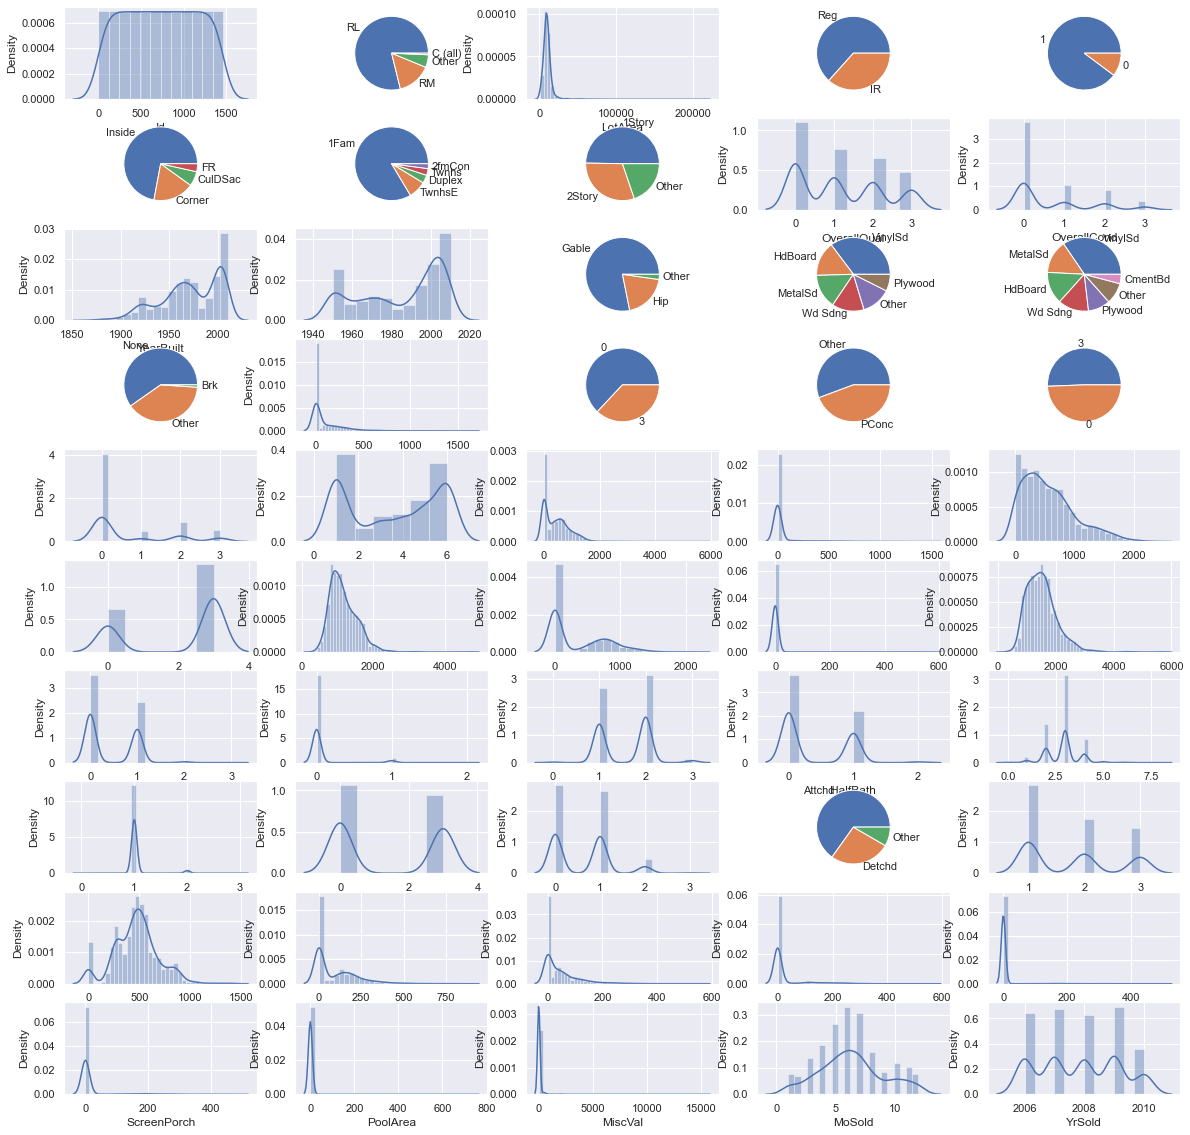

In [19]:
fig, axes = plt.subplots(10, 5, figsize=(20, 20))
colors = sns.color_palette('pastel')[0:5]
for ax, col in zip(axes.flatten(), data_train.columns):
    if col in cat_cols:
        ax.pie(data_train[col].value_counts(), labels=data_train[col].value_counts().index)
    else:
        sns.distplot(data_train[col], ax=ax)

In [24]:
X = data_train.drop(target+['Id'], axis=1)
y = data_train[target]
data_test = data_test.drop('Id', axis = 1)

## 3.Построение модели

### 3.1 Linear Regression

In [ ]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)


regressor = Pipeline(steps=[
    ("preproc", preprocessor),
    ("model", ElasticNet()),
])


PARAMS = {'model__alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 
                    10.0, 20, 50, 100, 500, 1000 ]
        }
                    
grid_search = GridSearchCV(
    estimator=regressor,
    param_grid=PARAMS,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    cv=10
)

linear_reg = grid_search.fit(X, y)

In [40]:
print(f"best score: {linear_reg.best_score_}")
print(f"best params: {linear_reg.best_params_}")

best score: -34635.75170475967
best params: {'model__alpha': 0.1}


In [45]:
submission["SalePrice"] = linear_reg.predict(data_test)
submission.to_csv("Submissions/linear_reg.csv", index=False)

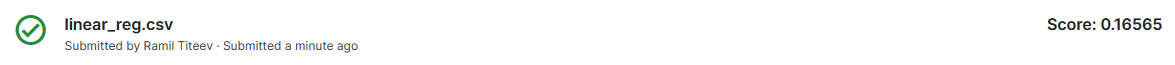

### 3.2 Random Forest

In [95]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

regr = Pipeline(steps=[
    ("preproc", preprocessor),
    ("model", RandomForestRegressor(random_state=42)),
])

PARAMS = {
    'model__n_estimators': [100], #[100, 150, 200, 250, 300],
    'model__max_depth': [14]#[1,3,5,7,9,10,12,14,15,17,20]
}
# regr = RandomForestClassifier(random_state=42, max_depth=15, n_estimators=200)
grid_search = GridSearchCV(regr, PARAMS, scoring="neg_root_mean_squared_error", cv=5)
rf = grid_search.fit(X, y.values.ravel())

In [67]:
print(f"best score: {rf.best_score_}")
print(f"best params: {rf.best_params_}")

best score: -31066.2843354112
best params: {'model__max_depth': 14, 'model__n_estimators': 100}


In [89]:
submission["SalePrice"] = rf.predict(data_test)
submission.to_csv("Submissions/rf_with_CV.csv", index=False)

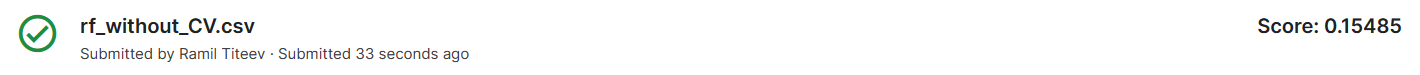

### 3.3 CatBoost

In [69]:
from catboost import CatBoostRegressor

In [73]:
catboost = CatBoostRegressor(
    cat_features=cat_cols,
    logging_level="Silent",
    eval_metric="RMSE:hints=skip_train~false",
    grow_policy="Lossguide",
    metric_period=1000
)

PARAMS = {
    "n_estimators": [200], #[5, 10, 50, 100, 150, 200, 250, 300, 500, 1000],
    "learning_rate": [0.1], #[0.01, 0.02, 0.04, 0.05, 0.1, 0.2, 0.3, 0.5],
    "max_depth":[4] #np.arange(4, 10, 1),
}

catboost.grid_search(PARAMS, X, y, cv=5, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 23054.3365357	best: 23054.3365357 (0)	total: 18.1s	remaining: 0us
Estimating final quality...


{'params': {'depth': 4, 'iterations': 200, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0, 199],
              'test-RMSE-mean': [179859.98217749823, 30274.30383427539],
              'test-RMSE-std': [4566.915093898623, 7684.507711677022],
              'train-RMSE-mean': [179970.26166459575, 15422.214709137246],
              'train-RMSE-std': [1332.3486458716045, 606.2313536543567]})}

In [88]:
submission["SalePrice"] = catboost.predict(data_test)
submission.to_csv("Submissions/catboost.csv", index=False)

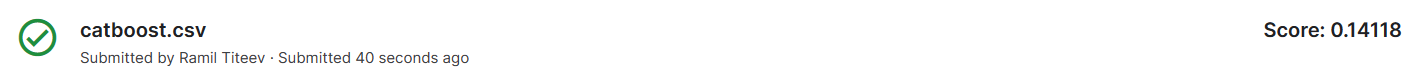